In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from concurrent.futures import ThreadPoolExecutor
import joblib

Function to compute Relative Strength Index (RSI)

In [2]:
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

Function to compute Bollinger Bands

In [3]:
def compute_bollinger_bands(data, window=20, num_sd=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    data['Bollinger_Upper'] = rolling_mean + (rolling_std * num_sd)
    data['Bollinger_Lower'] = rolling_mean - (rolling_std * num_sd)
    return data

Data Collection

In [4]:
def collect_data(ticker, start_date, end_date):
    try:
        # Fetch historical data using yfinance
        data = yf.download(ticker, start=start_date, end=end_date)
        
        # Ensure the index is a DatetimeIndex
        data.reset_index(inplace=True)
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        
        # Handle missing values
        data.ffill(inplace=True)
        
        return data
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

Fetch data for multiple tickers

In [5]:
def fetch_multiple_tickers(tickers, start_date, end_date):
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(collect_data, ticker, start_date, end_date): ticker for ticker in tickers}
        results = {ticker: future.result() for future, ticker in futures.items()}
    
    return results

Data Preprocessing

In [6]:
def preprocess_data(data):
    # Handle missing values and calculate technical indicators
    data.dropna(inplace=True)
    
    # Existing indicators
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['Volatility'] = data['Close'].rolling(window=10).std()
    data['RSI'] = compute_rsi(data['Close'])
    data = compute_bollinger_bands(data)
    
    # Additional indicators
    data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['Stochastic_Oscillator'] = (data['Close'] - data['Low'].rolling(window=14).min()) / (data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min())
    
    # Add lag features and other relevant features
    for lag in range(1, 6):
        data[f'Lag{lag}'] = data['Close'].shift(lag)
    data['Day_of_Week'] = data.index.dayofweek
    data['Month'] = data.index.month

    data.dropna(inplace=True)  # Drop rows with NaN values after feature creation

    # Define features (X) and target (y)
    features = ['MA10', 'MA50', 'Volatility', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Day_of_Week', 'Month', 'MACD', 'MACD_Signal', 'Stochastic_Oscillator'] + [f'Lag{lag}' for lag in range(1, 6)]
    X = data[features]
    y = data['Close']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save the scaler for future use
    joblib.dump(scaler, 'scaler.pkl')
    print("Scaler saved as 'scaler.pkl'")

    return X_train_scaled, X_test_scaled, y_train, y_test, data, scaler

Train Model with Hyperparameter Tuning

In [7]:
def train_model(X_train, y_train):
    base_estimator = DecisionTreeRegressor(max_depth=5)
    model = AdaBoostRegressor(estimator=base_estimator, random_state=42)
    
    # Hyperparameter tuning using Grid Search
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Save the trained model
    joblib.dump(grid_search.best_estimator_, 'adaboost_model.pkl')
    print("Model saved as 'adaboost_model.pkl'")
    
    return grid_search.best_estimator_

Evaluate Model and Visualize Results

In [8]:
def evaluate_model(model, X_test, y_test, data, scaler):
    predictions = model.predict(X_test)
    
    # Evaluation metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # Since this is a regression model, converting to classification for accuracy/F1 calculation
    y_test_class = (y_test > y_test.mean()).astype(int)
    predictions_class = (predictions > y_test.mean()).astype(int)
    
    accuracy = accuracy_score(y_test_class, predictions_class)
    f1 = f1_score(y_test_class, predictions_class)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-Squared: {r2:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plotting actual vs predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.values, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='red')
    plt.title("Actual vs Predicted Stock Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Plot accuracy and loss vs. epoch
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(model.estimators_)), model.estimator_errors_, label='Loss (Error)')
    plt.plot(range(len(model.estimators_)), [accuracy] * len(model.estimators_), label='Accuracy')
    plt.title("Accuracy and Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.show()

Generate Trading Signal

In [9]:
def generate_trade_signal(processed_data, model, scaler):
    last_price = processed_data['Close'].iloc[-1]
    last_features = processed_data[['MA10', 'MA50', 'Volatility', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Day_of_Week', 'Month', 'MACD', 'MACD_Signal', 'Stochastic_Oscillator'] + [f'Lag{lag}' for lag in range(1, 6)]].iloc[-1].values.reshape(1, -1)
    last_features_scaled = scaler.transform(last_features)
    predicted_price = model.predict(last_features_scaled)[0]

    if predicted_price > last_price:
        return 'buy'
    elif predicted_price < last_price:
        return 'sell'
    else:
        return 'hold'

Predict Future Prices

In [10]:
def predict_future_prices(model, processed_data, scaler, days_to_predict):
    future_features = []
    last_row = processed_data[['MA10', 'MA50', 'Volatility', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Day_of_Week', 'Month', 'MACD', 'MACD_Signal', 'Stochastic_Oscillator'] + [f'Lag{lag}' for lag in range(1, 6)]].iloc[-1].values
    
    for _ in range(days_to_predict):
        future_features.append(last_row)
        last_row = np.roll(last_row, -1)  # Shift features to simulate next day's input
        last_row[-1] = model.predict(scaler.transform([last_row]))[0]  # Update last feature with predicted price
    
    future_features_scaled = scaler.transform(future_features)
    future_prices = model.predict(future_features_scaled)
    
    return future_prices

Plot Future Projections

In [11]:
def plot_future_projections(processed_data, future_prices, days_to_predict):
    plt.figure(figsize=(14, 7))
    plt.plot(processed_data['Close'].values, label='Actual Prices', color='blue')
    plt.plot(range(len(processed_data), len(processed_data) + days_to_predict), future_prices, label='Predicted Future Prices', color='red')
    plt.title("Actual and Predicted Future Stock Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

Main Execution Flow for Jupyter Notebook

In [12]:
ticker = input("Enter Stock Ticker: ")
start_date = input("Enter Start Date (YYYY-MM-DD): ")
end_date = input("Enter End Date (YYYY-MM-DD): ")

Collect data

[*********************100%%**********************]  1 of 1 completed


Scaler saved as 'scaler.pkl'
Best hyperparameters: {'learning_rate': 1, 'n_estimators': 100}
Model saved as 'adaboost_model.pkl'
Mean Squared Error: 4.1030
Mean Absolute Error: 1.1901
R-Squared: 0.9969
Accuracy: 0.9758
F1 Score: 0.9630


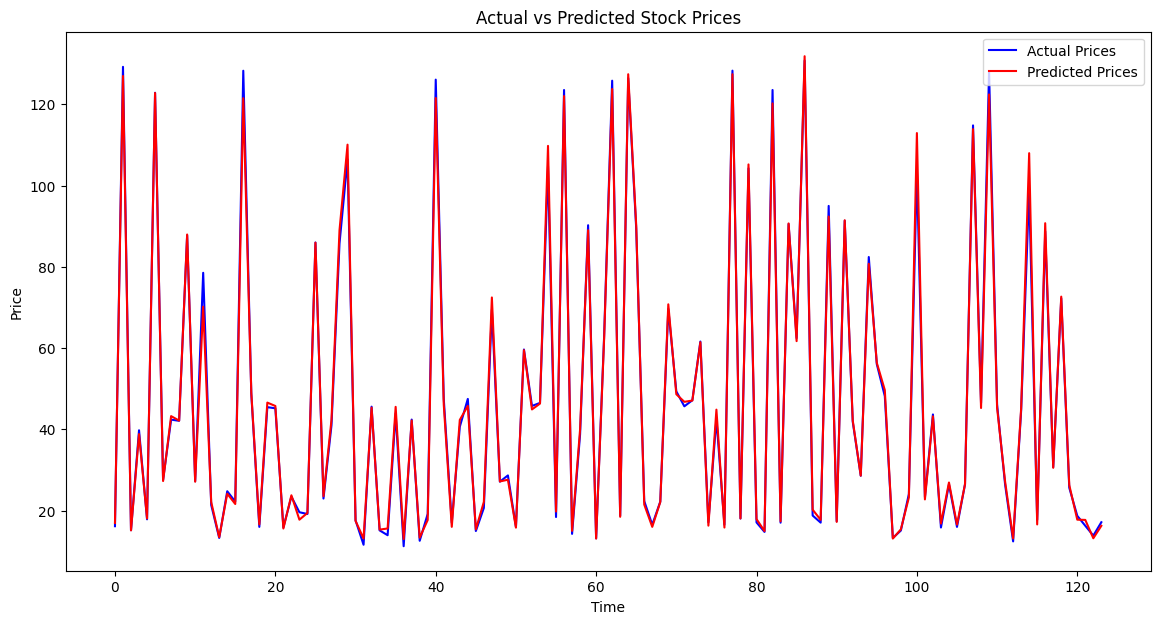

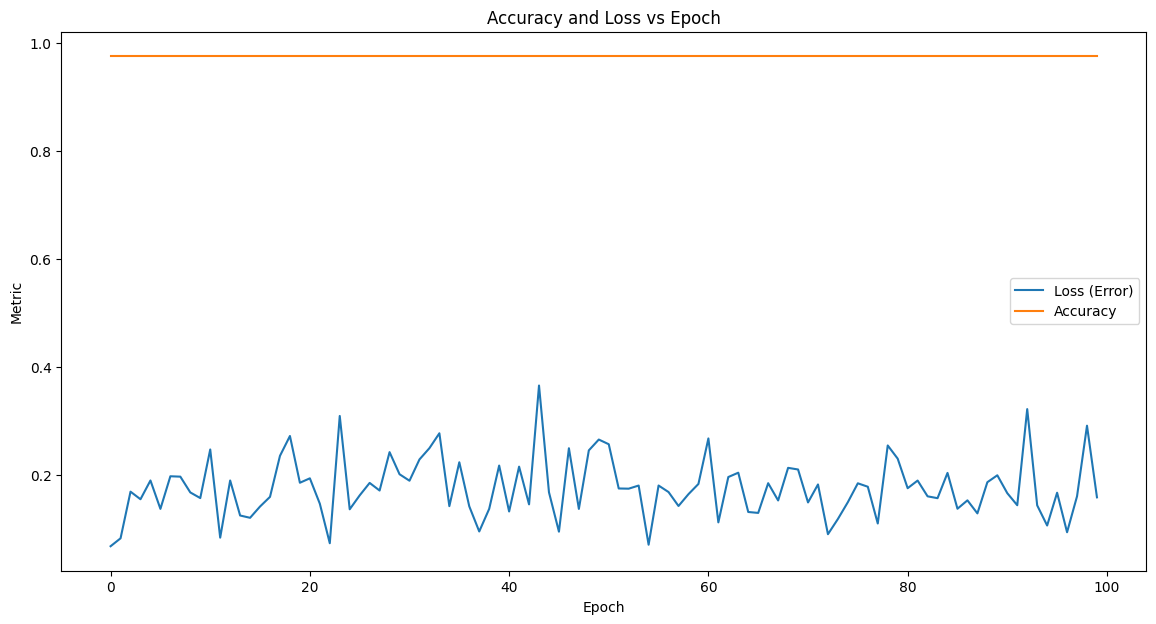

C:\Users\21010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Trading Signal: buy


C:\Users\21010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\21010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\21010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\21010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\21010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Us

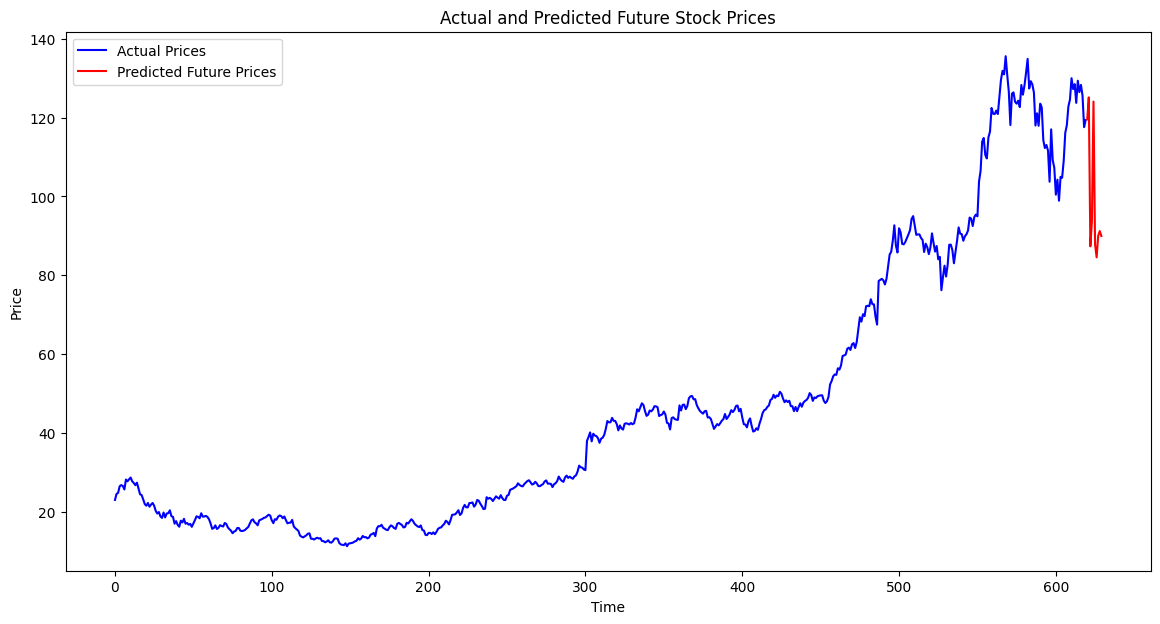

In [13]:
data = collect_data(ticker, start_date, end_date)

if data is not None:
    X_train, X_test, y_train, y_test, processed_data, scaler = preprocess_data(data)
    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test, processed_data, scaler)
    signal = generate_trade_signal(processed_data, model, scaler)
    print(f"Trading Signal: {signal}")
    
    days_to_predict = int(input("Enter number of days to predict into the future: "))
    future_prices = predict_future_prices(model, processed_data, scaler, days_to_predict)
    plot_future_projections(processed_data, future_prices, days_to_predict)
else:
    print("Failed to collect data. Please check the ticker and dates.")